<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 24: Simulation-based (Likelihood-free) Inference</h1>


<a name='section_24_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_1">L24.1 Simple bump-on-power-law example and Explicit Likelihood</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_1">L24.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_2">L24.2 Implicit Likelihood Method 1: Approximate Bayesian Computation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_2">L24.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_3">L24.3 Implicit Likelihood Method 2: Neural Likelihood-ratio Estimation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_3">L24.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_4">L24.4 Implicit Likelihood Method 3: Neural Posterior Estimation</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_4">L24.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_24_5">L24.5 A more complicated example: distribution of point sources in a 2D image</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_24_5">L24.5 Exercises</a></td>
    </tr>
</table>

In [1]:
#>>>RUN: L24.0-runcell00

!pip install --upgrade emcee corner pytorch-lightning tqdm nflows

In [2]:
#>>>RUN: L24.0-runcell01

import torch                            #https://pytorch.org/docs/stable/torch.html
import torch.nn as nn                   #https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F         #https://pytorch.org/docs/stable/nn.functional.html
from torch.utils.data import TensorDataset, DataLoader, random_split  #https://pytorch.org/docs/stable/data.html
import numpy as np                      #https://numpy.org/doc/stable/
import emcee                            #https://emcee.readthedocs.io/en/stable/
from scipy.stats import poisson         #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html
from scipy.stats import chi2            #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html
from scipy.optimize import basinhopping #https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
from tqdm import tqdm                   #https://pypi.org/project/tqdm/
import matplotlib.pyplot as plt         #https://matplotlib.org/stable/api/pyplot_summary.html#module-matplotlib.pyplot
import pytorch_lightning as pl          #https://lightning.ai/docs/pytorch/stable/
import corner                           #https://corner.readthedocs.io/en/latest/
import warnings

In [3]:
#>>>RUN: L24.0-runcell02
warnings.filterwarnings('ignore')

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_24_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.1 Simple bump-on-power-law example and Explicit Likelihood</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_0) | [Exercises](#exercises_24_1) | [Next Section](#section_24_2) |


In [4]:
#>>>RUN: L24.1-runcell01

def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

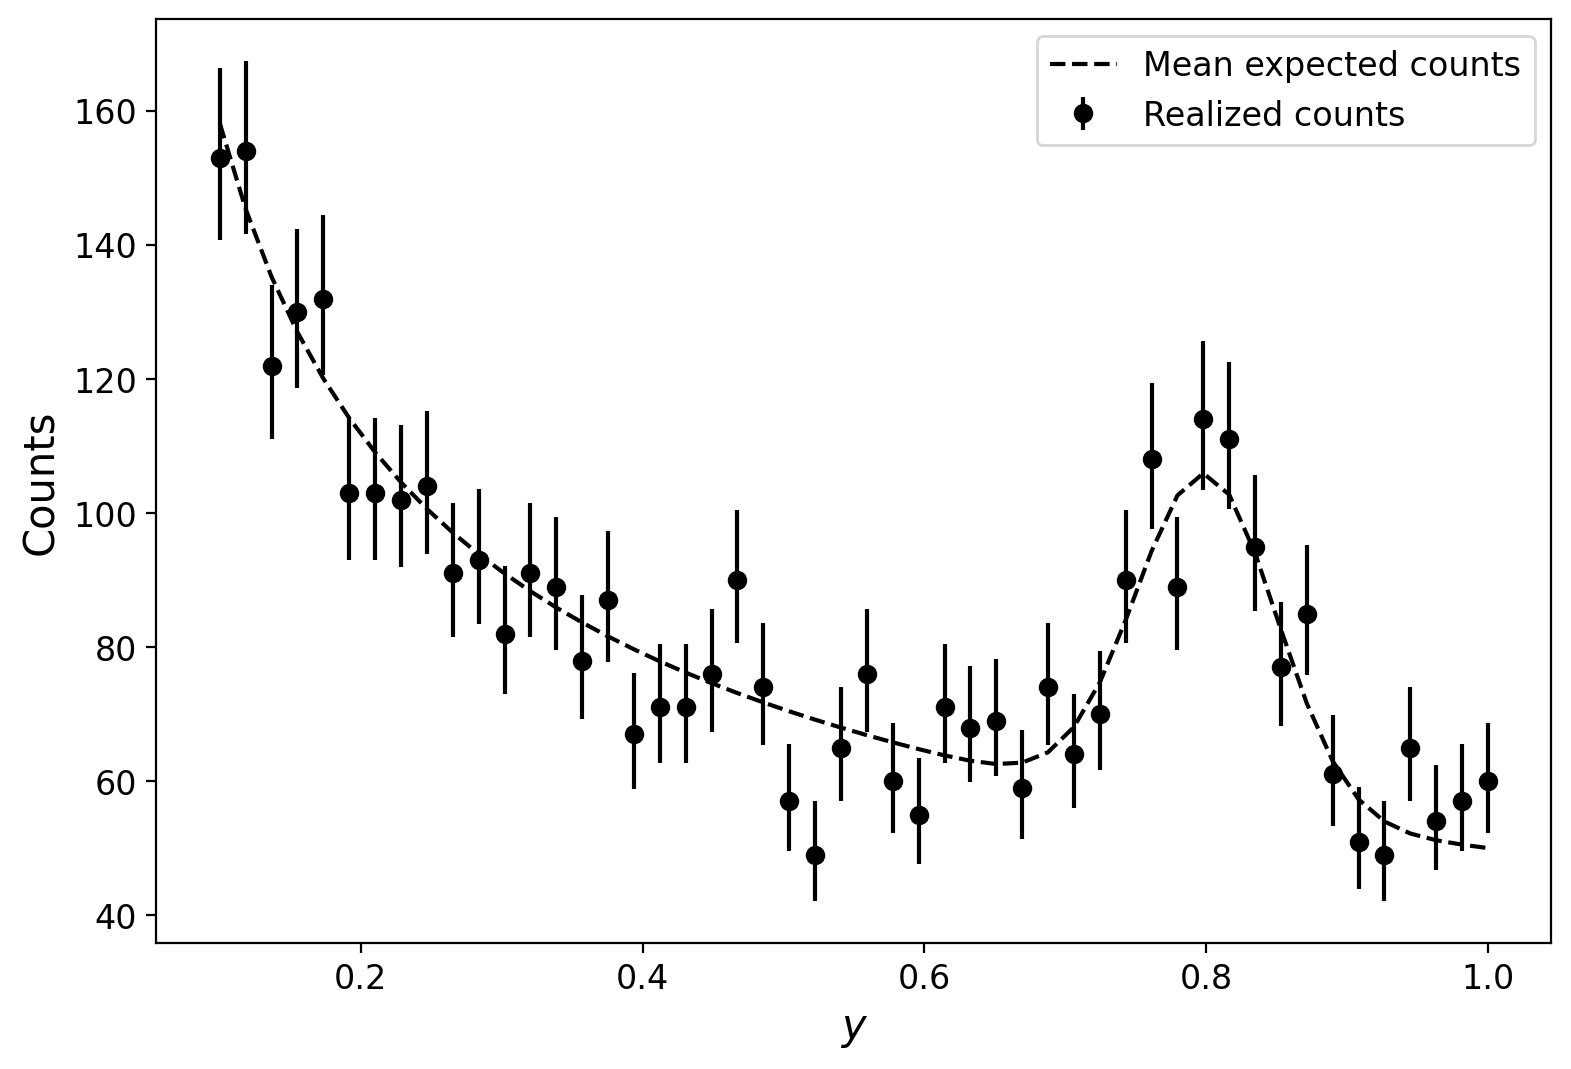

In [5]:
#>>>RUN: L24.1-runcell02

#instead of sqrt(N) uncertainties, get the full asymmetric uncertainty using a chi2
def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
np.random.seed(42)
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T #getting asymmetric errorbars

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()

In [6]:
#>>>RUN: L24.1-runcell03

def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

In [7]:
#>>>RUN: L24.1-runcell04

def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([50, 0.8], y, x)

-178.44275030942168

In [8]:
#>>>RUN: L24.1-runcell05

# Initial guess for the parameters
initial_guess = [100., 0.1]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (50, 0.8)))


MLE parameters: [53.49156979  0.79989477]; true parameters: (50, 0.8)


In [9]:
#>>>RUN: L24.1-runcell06

def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1170.61it/s]


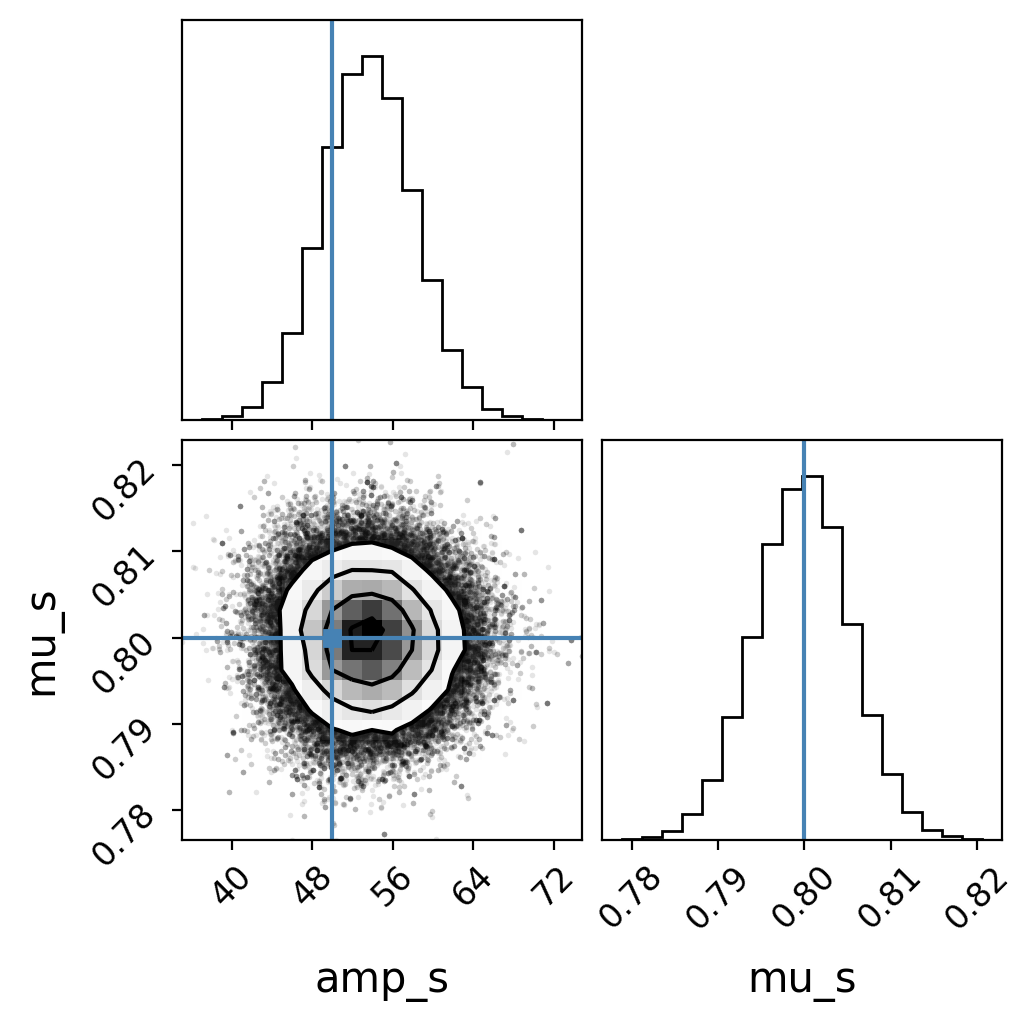

In [10]:
#>>>RUN: L24.1-runcell07

# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True)

#make the corner plot with true values as lines
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], smooth=.1);


<a name='exercises_24_1'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_1) | [Next Section](#section_24_2) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.1.1</span>

The calculations in this section only inferred two of the signal parameters, $A_s$ (`amp_s`) and $\mu_s$ (`mu_s`). Complete the code below to also infer $\sigma_s$ (`std_s`) via likelihood maximization (negative log-likelihood minimization). Report your result for the value of $\sigma_s$ as a number with precision `1e-4`.

<br>

In [11]:
#>>>EXERCISE: L24.1.1

def log_like_sig2(params, y, x):
    #Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a fixed PL background.
    
    amp_s, mu_s, sta_s = params
    amp_b, exp_b = 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, sta_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

# Initial guess for the parameters
initial_guess = [100., 0.1, 0.01]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1), (0.001, .2))}

# Perform the optimization using basinhopping
opt2 = basinhopping(lambda thetas: -log_like_sig2(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt2.x, (50, 0.8, 0.05)))

MLE parameters: [5.31139563e+01 7.99860190e-01 5.06056103e-02]; true parameters: (50, 0.8, 0.05)


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.1.2</span>

Now generate the posterior distributions by running MCMC on the 3 parameters, as we did above for the two parameters. Make a corner plot, as done at the end of this section. Which parameters appear to be correlated?

A) `amp_s` and `mu_s`

B) `amp_s` and `std_s`

C) `mu_s` and `std_s`

<br>

100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1156.61it/s]


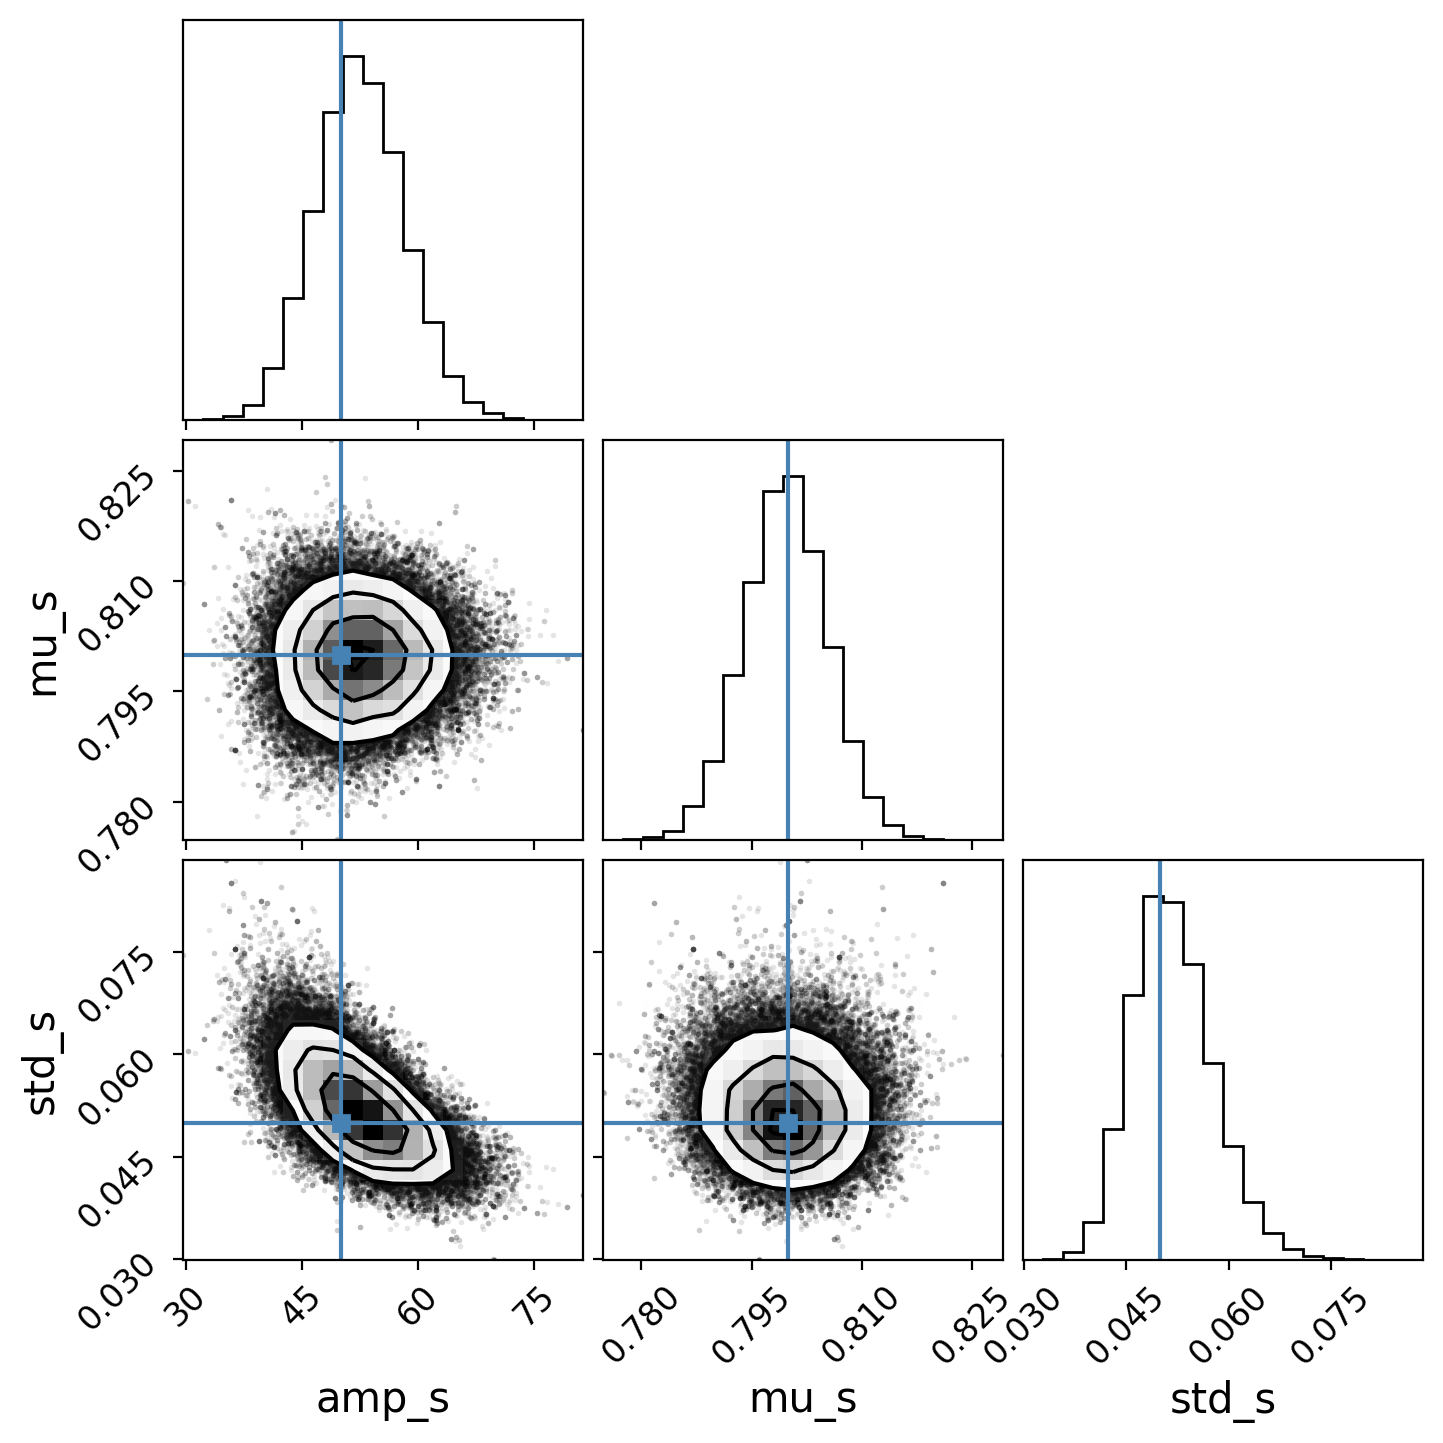

In [12]:
#>>>EXERCISE: L24.1.2

def log_prior2(thetas):
    #Log-prior function for a Gaussian bump (amp_s, mu_s, std_s) on top of a fixed PL background.
    
    amp_s, mu_s, std_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2 and 0 < std_s < 0.5:
        return 0
    else:
        return -p.inf

def log_post2(thetas, y, x):
    #Log-posterior function for a Gaussian bump (amp_s, mu_s, std_s) on top of a fixed PL background.
    
    lp = log_prior2 (thetas)
    if not np.isfinite(lp):
        return np. inf
    else:
        return lp + log_like_sig2(thetas, y, x)
    
    
# Sampling with `emcee`
ndim, nwalkers = 3, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post2, args=(y, x))

# using basinhopping optimization from EXERCISE: L24.1.1 (i.e., opt2)
pos = opt2.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

# Plot posterior samples
flat_samples_3par = sampler.get_chain(discard=1000, flat=True)
corner.corner (flat_samples_3par, labels=["amp_s", "mu_s", "std_s"], truths=[50, 0.8, 0.05], smooth=.1);

<a name='section_24_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.2 Implicit Likelihood Method 1: Approximate Bayesian Computation</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_1) | [Exercises](#exercises_24_2) | [Next Section](#section_24_3) |


In [13]:
#>>>RUN: L24.2-runcell01

def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and abscissa points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

#we had defined this funciton previously
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

# Test it out
y = np.linspace(0.1, 1, 50)
bump_simulator([50, 0.8], y)

array([180, 171, 150, 121, 111,  95, 104,  85, 102,  92, 108,  83, 101,
        98, 102,  89,  79,  85,  74,  67,  69,  66,  50,  66,  75,  65,
        83,  67,  80,  65,  56,  56,  71,  65,  80,  93,  86, 105,  98,
       115,  98,  68,  68,  68,  44,  58,  61,  51,  58,  54])

In [14]:
#>>>RUN: L24.2-runcell02

#define the simulated data again, if you have not done so in the previous section

def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
np.random.seed(42)
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

In [15]:
#>>>RUN: L24.2-runcell03

x_fwd = bump_simulator([50, 0.8], y)
eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
eps

180.82

In [16]:
#>>>RUN: L24.2-runcell04

def abc(y, x, eps_thresh=500., n_samples=1000):
    """ABC algorithm for Gaussian bump model.

    Args:
        y (np.ndarray): Abscissa points.
        x (np.ndarray): Data counts.
        eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
        n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.

    Returns:
        np.ndarray: Accepted samples approximating the posterior p(theta|x).
    """
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 5_000
post_samples = abc(y, x, eps_thresh=200, n_samples=n_samples)

Accepted Samples: 100%|█| 5000/5000 [00:12<00:00, 389.18samples/s, acceptance_ra


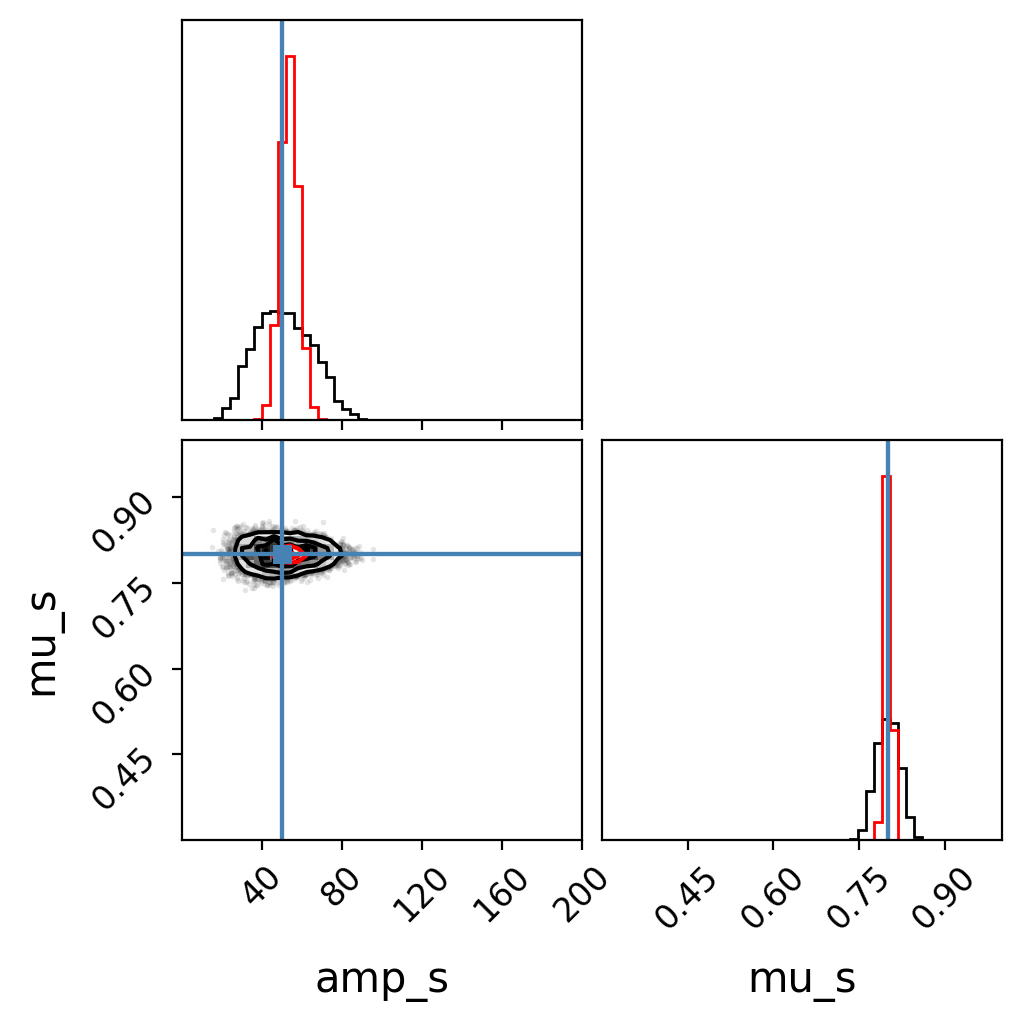

In [17]:
#>>>RUN: L24.2-runcell05

#note: here we also plot `flat_samples`, which was defined in cell `L24.1-runcell07`
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

<a name='exercises_24_2'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_2) | [Next Section](#section_24_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.2.1</span>

We can attempt to use our knowledge of MSE to yield a more biased approach to finding the best fit parameters. What we can do is weight the parameers by `1./eps`. Thus, larger values of `eps`, that are closer to acceptance threshold, will be weighted LESS. Complete the code below in order to make corner plots. What happens to the best fit parameters?

A) The algorithm finds the same best fit parameters.\
B) The algorithm cannot find the best fit parameters.\
C) The algorithm finds a narrower range for `amp_s` than `mu_s`.\
D) The algorithm finds a narrower range for `mu_s` than `amp_s`.

<br>

In [18]:
#>>>EXERCISE: L24.2.1

def abc_weight(y, x, n_samples=1000,eps_thresh=500):
    #ABC algorithm for Gaussian bump model.
    #
    #Args:
    #    y (np.ndarray): Abscissa points.
    #    x (np.ndarray): Data counts.
    #    eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
    #    n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.
    #
    #Returns:
    #    np.ndarray: Accepted samples approximating the posterior p(theta|x).

    samples = []
    weights = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            weights.append(1e3/eps)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples), np.array(weights)*len(samples)/np.sum(weights)

n_samples = 5_000
post_samples_weight,sample_weights = abc_weight(y, x, n_samples=n_samples)

fig = corner.corner(post_samples_weight,weights=sample_weights, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);


Accepted Samples:  60%|▌| 2988/5000 [00:01<00:01, 1952.81samples/s, acceptance_rIOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<a name='section_24_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.3 Implicit Likelihood Method 2: Neural Likelihood-ratio Estimation</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_2) | [Exercises](#exercises_24_3) | [Next Section](#section_24_4) |


In [19]:
#>>>RUN: L24.3-runcell01

n_train = 50_000

# Simulate training data
theta_samples = np.random.uniform(low=[0, 0], high=[200, 1], size=(n_train, 2))  # Parameter proposal
x_samples = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples)])
print("here is one set of random data poitns:",x_samples[0])

# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data to make the NN understand these guys
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

100%|██████████████████████████████████| 50000/50000 [00:00<00:00, 75401.59it/s]

here is one set of random data poitns: [141 140 136 104 120  97 113 113  99 104  86  88 107 109 105 121 153 181
 226 229 212 182 173 144  89  70  75  64  60  53  51  61  61  72  52  48
  50  48  56  55  59  57  58  51  50  50  51  36  50  54]


In [20]:
#>>>RUN: L24.3-runcell02

def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

In [21]:
#>>>RUN: L24.3-runcell03

class NeuralRatioEstimator(pl.LightningModule):
    """ Simple neural likelihood-to-evidence ratio estimator, using an MLP as a parameterized classifier.
    """
    def __init__(self, x_dim, theta_dim):
        super().__init__()
        self.classifier = build_mlp(input_dim=x_dim + theta_dim, hidden_dim=128, output_dim=1, layers=4)

    def forward(self, x):
        return self.classifier(x)

    def loss(self, x, theta):
        #x is our input histogram, the first thing we do is clone it using repeat_interleave

        # Repeat x in groups of 2 along batch axis
        x = x.repeat_interleave(2, dim=0)

        #Now we need to make a random permutation of the theta parameters to make an incorrect pairing
        # Get a shuffled version of theta
        theta_shuffled = theta[torch.randperm(theta.shape[0])]

        # We insert this into our new theta array to get the correct an incorrect pairings
        # Interleave theta and shuffled theta
        theta = torch.stack([theta, theta_shuffled], dim=1).reshape(-1, theta.shape[1])

        #Now we can define what is correct, and what is not labels[1::2]=0.0, will take [1,1,1,...]=>[1,0,1,0,..]
        #(ie first is correct and 2nd is incorrect and so on)
        # Get labels; ones for pairs from joint, zeros for pairs from marginals
        labels = torch.ones(x.shape[0], device=x.device)
        labels[1::2] = 0.0

        # Pass through parameterized classifier to get logits
        # now merge the inputs to x and theta into one vecotr and apply the mlp (note self function does this)
        logits = self(torch.cat([x, theta], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        #Finally binary cross entropy with our truth
        return nn.BCELoss(reduction='none')(probs, labels)


    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [22]:
#>>>RUN: L24.3-runcell04

# Lets test out the above code, by taking 64 random histograms (x_samples[:64]) and computing the loss of the MLP
# Evaluate loss; initially it should be around -log(0.5) = 0.693
nre = NeuralRatioEstimator(x_dim=50, theta_dim=2)
nre.loss(x_samples[:64], theta_samples[:64])

tensor([0.6542, 0.7339, 0.6538, 0.7341, 0.6534, 0.7344, 0.6537, 0.7339, 0.6540,
        0.7337, 0.6532, 0.7346, 0.6545, 0.7335, 0.6537, 0.7342, 0.6525, 0.7356,
        0.6535, 0.7343, 0.6554, 0.7322, 0.6536, 0.7342, 0.6538, 0.7341, 0.6552,
        0.7328, 0.6536, 0.7341, 0.6537, 0.7341, 0.6539, 0.7336, 0.6534, 0.7346,
        0.6535, 0.7346, 0.6531, 0.7350, 0.6553, 0.7332, 0.6537, 0.7343, 0.6534,
        0.7346, 0.6540, 0.7339, 0.6551, 0.7327, 0.6535, 0.7345, 0.6537, 0.7342,
        0.6539, 0.7340, 0.6553, 0.7330, 0.6561, 0.7313, 0.6538, 0.7339, 0.6541,
        0.7336, 0.6536, 0.7341, 0.6536, 0.7342, 0.6533, 0.7347, 0.6539, 0.7338,
        0.6537, 0.7343, 0.6530, 0.7352, 0.6538, 0.7343, 0.6538, 0.7339, 0.6537,
        0.7345, 0.6546, 0.7333, 0.6541, 0.7338, 0.6540, 0.7336, 0.6541, 0.7339,
        0.6534, 0.7345, 0.6531, 0.7351, 0.6539, 0.7338, 0.6521, 0.7358, 0.6541,
        0.7335, 0.6538, 0.7341, 0.6562, 0.7316, 0.6539, 0.7341, 0.6545, 0.7330,
        0.6560, 0.7322, 0.6529, 0.7351, 

In [23]:
#>>>RUN: L24.3-runcell05

val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [24]:
#>>>RUN: L24.3-runcell06

trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=nre, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 73.0 K | train
--------------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


In [25]:
#>>>RUN: L24.3-runcell07

def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """
    #convert to torch and normalize inputs
    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std
    #Ensures array input is correct
    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)
    #now apply the NN
    return nre.classifier(torch.cat([x, theta], dim=-1)).squeeze().detach().numpy()

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

log_like(theta_test, x_test)

array(4.5974994, dtype=float32)

In [26]:
#>>>RUN: L24.3-runcell08

def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

In [27]:
#>>>RUN: L24.3-runcell09

ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 2000, progress=True);

100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 387.53it/s]


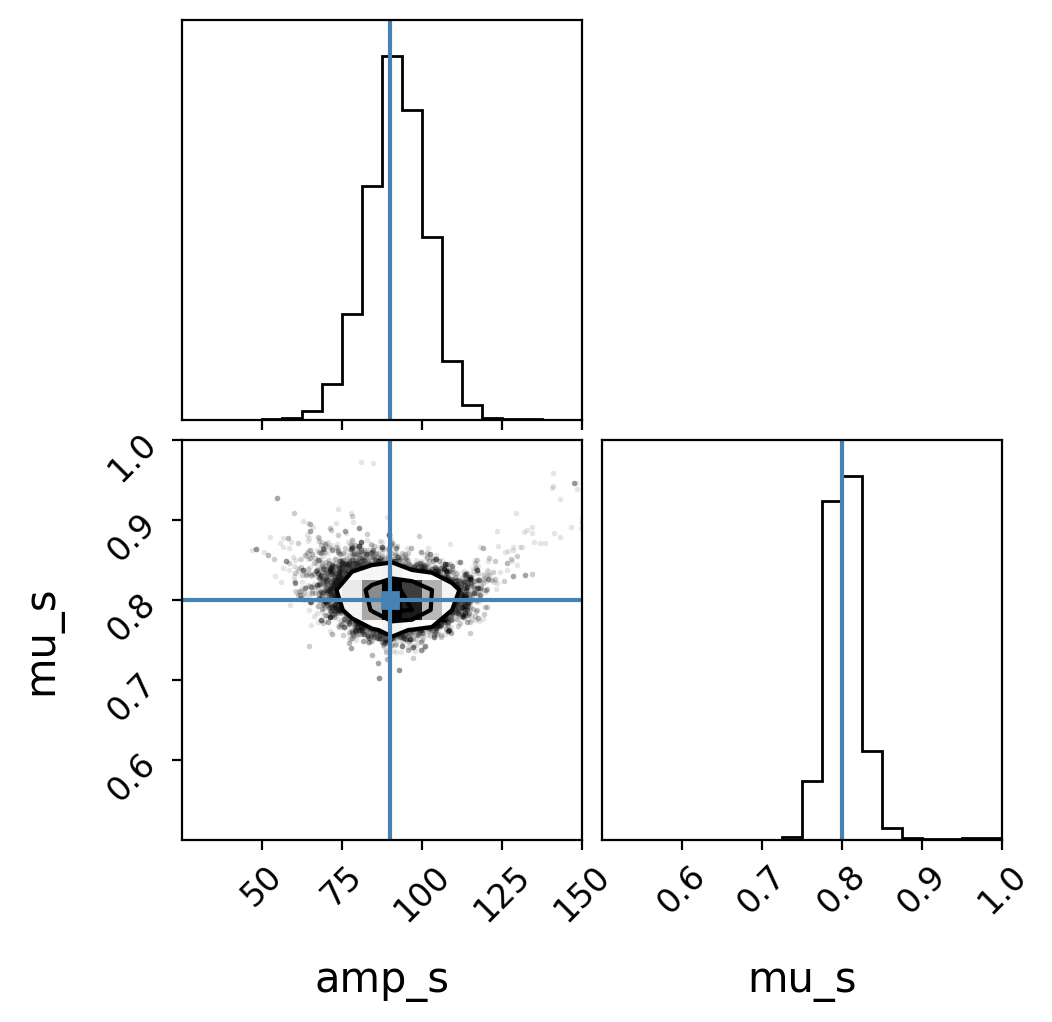

In [28]:
#>>>RUN: L24.3-runcell10

flat_samples_nre = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples_nre, labels=["amp_s", "mu_s"], truths=[90, 0.8], range=[(25, 150), (0.5, 1.)]);


<a name='exercises_24_3'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_3) | [Next Section](#section_24_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.3.1</span>

Complete the code below to compare the NRE approach with the previous explicit likelihood (EL) approach from section 1. How do the corner plots compare? Is one better?

A) The results are comparable with no clear winner.

B) The results are comparable, but the NRE method is better (producing a narrower range of results).

C) The results are comparable, but the EL method is better (producing a narrower range of results).


<br>

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1112.52it/s]


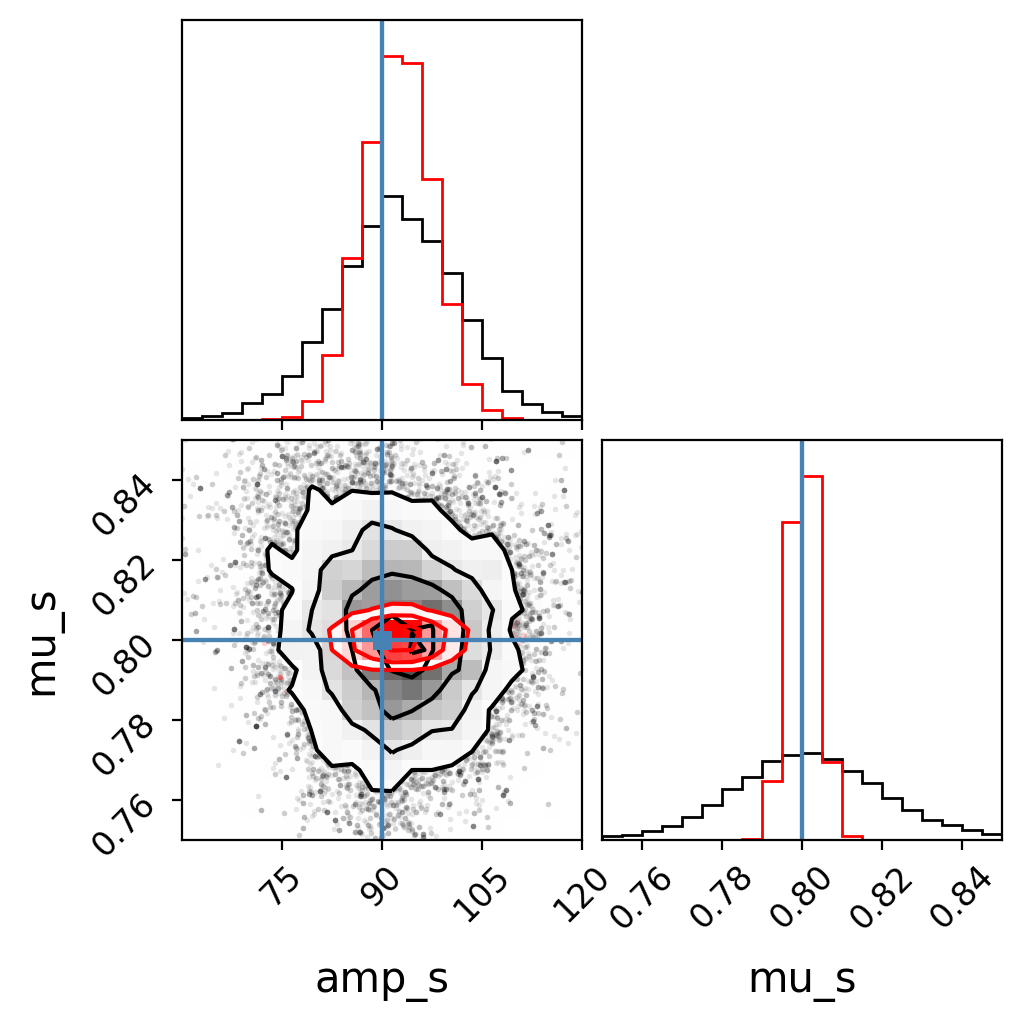

In [29]:
#>>>EXERCISE: L24.3.1

#First create a figure with the result from `flat_samples_nre` above
fig=corner.corner(flat_samples_nre, labels=["amp_s", "mu_s"], truths=[90, 0.8], range=[(60, 120), (0.75, 0.85)]);

def log_like_sig_old(params, y, x):
    #Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.

    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

def log_post_old(thetas, y, x):
    #Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig_old(thetas, y, x)

    
# Sampling with `emcee`
## see  above, be sure to use x_test for the new x values and  log_post_old
#YOUR CODE HERE
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler (nwalkers, ndim, log_post_old, args=(y, x_test) )
pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 2000, progress=True);

#plot the new values from mcmc in red
flat_samples_mcmc = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples_mcmc,color='red', labels=["amp_s", "mu_s"], truths=[90, 0.8],fig=fig, range=[(60, 120), (0.75, 0.85)]);


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.3.2</span>

Now lets look into a situation where this approach starts to break down. Edit the variable `theta_samples_tmp` to set the amplitude range of our sample to be from 0 to 2000 (previously it was 0 to 200, defined earlier in this section). How does the fit look now?

A) The fit is comparable or better.

B) The fit is okay in `amp_s` but not `mu_s`.

C) The fit is okay in `mu_s` but not `amp_s`.

D) The fit is way off in both `amp_s` and `mu_s`.


<br>

100%|██████████████████████████████████| 50000/50000 [00:00<00:00, 75014.69it/s]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 73.0 K | train
--------------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.
100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 440.75it/s]


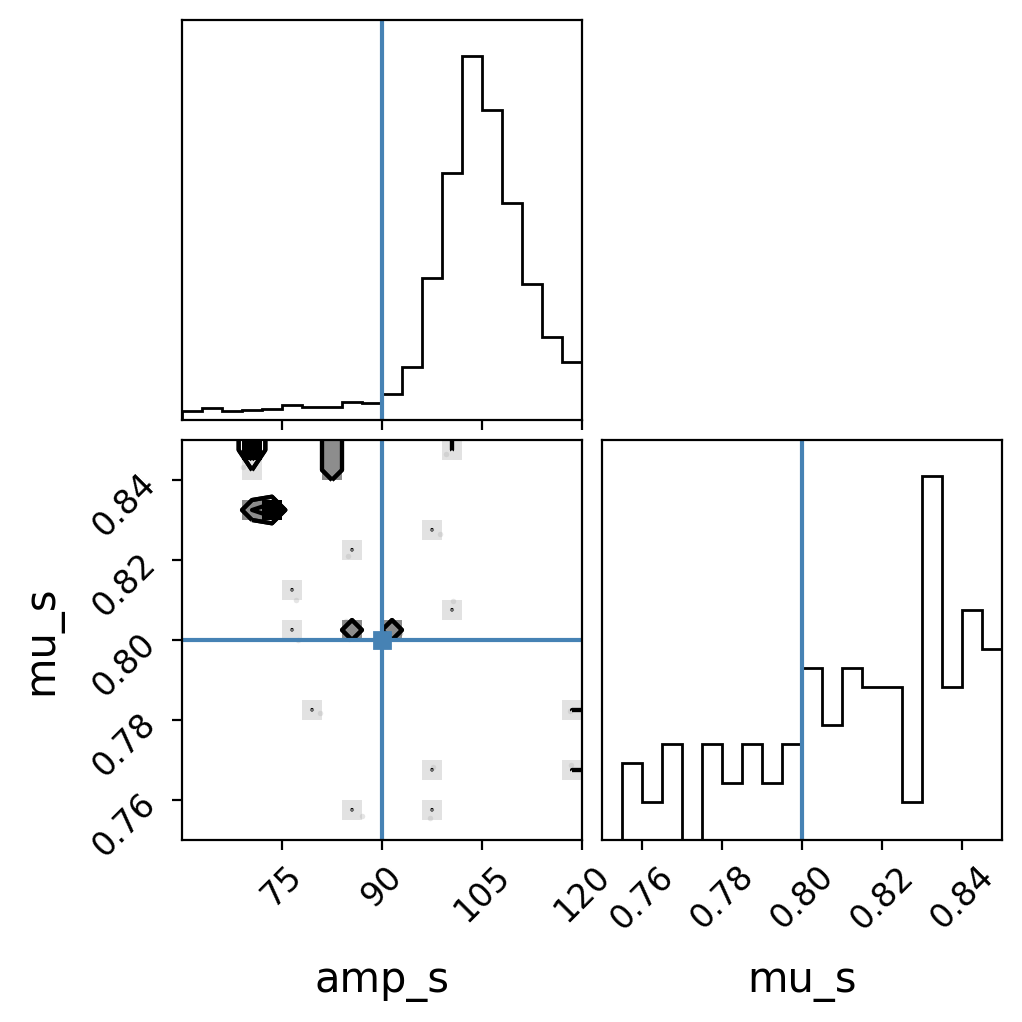

In [31]:
#>>>EXERCISE: L24.3.2

n_train = 50_000

# Simulate training data
theta_samples_tmp = np.random.uniform(np.random.uniform(low=[0, 0], high=[2000, 1], size=(n_train, 2)))  
# Parameter proposal
x_samples_tmp = np.array([bump_simulator(theta, y) for theta in tqdm(theta_samples_tmp)])

# Convert to torch tensors
theta_samples_tmp = torch.tensor(theta_samples_tmp, dtype=torch.float32)
x_samples_tmp = torch.tensor(x_samples_tmp, dtype=torch.float32)

# Normalize the data
x_mean_tmp = x_samples_tmp.mean(dim=0)
x_std_tmp = x_samples_tmp.std(dim=0)
x_samples_tmp = (x_samples_tmp - x_mean_tmp) / x_std_tmp
theta_mean_tmp = theta_samples_tmp.mean(dim=0)
theta_std_tmp = theta_samples_tmp.std(dim=0)
theta_samples_tmp = (theta_samples_tmp - theta_mean_tmp) / theta_std_tmp

#training code
val_fraction = 0.1
batch_size = 128
n_samples_val_tmp = int(val_fraction * len(x_samples_tmp))
dataset_tmp = TensorDataset(x_samples_tmp, theta_samples_tmp)
dataset_train_tmp, dataset_val_tmp = random_split(dataset_tmp, [len(x_samples_tmp) - n_samples_val_tmp, n_samples_val_tmp])
train_loader_tmp = DataLoader(dataset_train_tmp, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader_tmp = DataLoader(dataset_val_tmp, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)#

nre_largesample = NeuralRatioEstimator(x_dim=50, theta_dim=2)
trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=nre_largesample, train_dataloaders=train_loader_tmp, val_dataloaders=val_loader_tmp);

def log_like(theta, x):
    """ Log-likelihood ratio estimator using trained classifier logits.
    """

    x = torch.Tensor(x)
    theta = torch.Tensor(theta)

    # Normalize
    x = (x - x_mean) / x_std
    theta = (theta - theta_mean) / theta_std

    x = torch.atleast_1d(x)
    theta = torch.atleast_1d(theta)

    return nre_largesample.classifier(torch.cat([x, theta], dim=-1)).squeeze().detach().numpy()

def log_post(theta, x):
    """ Log-posterior distribution, for sampling.
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(theta, x)

ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 2000, progress=True);

flat_samples_nre2 = sampler.get_chain(discard=1000, flat=True)
fig=corner.corner(flat_samples_nre2, labels=["amp_s", "mu_s"], truths=[90, 0.8], range=[(60, 120), (0.75, 0.85)]);


<a name='section_24_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.4 Implicit Likelihood Method 3: Neural Posterior Estimation</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_3) | [Exercises](#exercises_24_4) | [Next Section](#section_24_5) |


In [32]:
#>>>RUN: L24.4-runcell01

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [33]:
#>>>RUN: L24.4-runcell02

def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
print(samples.shape, log_prob.shape)

torch.Size([2, 100, 2]) torch.Size([2, 100])


In [34]:
#>>>RUN: L24.4-runcell03

class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16,d_hidden=32):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=d_hidden, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [35]:
#>>>RUN: L24.4-runcell04

npe = NeuralPosteriorEstimator(featurizer=build_mlp(input_dim=50, hidden_dim=128, output_dim=16, layers=4))
npe.loss(x_samples[:64], theta_samples[:64])

tensor([4.9333, 5.4453, 4.9966, 5.5865, 5.2304, 5.0432, 5.1796, 5.2532, 5.0253,
        5.2067, 4.6604, 5.1549, 5.1206, 5.0373, 4.9118, 5.2209, 4.9856, 5.2608,
        5.4136, 5.1883, 4.9862, 5.1468, 5.1799, 4.7873, 5.0624, 4.7734, 4.9276,
        5.4044, 4.9992, 4.8605, 5.4234, 5.1454, 5.5720, 5.4136, 4.8336, 5.4511,
        5.6643, 5.0964, 5.1465, 5.5018, 4.6265, 5.2835, 5.0470, 5.5425, 5.4823,
        5.5649, 5.2096, 5.2748, 4.7057, 5.3474, 5.5373, 4.9226, 5.5597, 4.6854,
        4.9741, 4.8484, 5.2317, 5.5279, 5.4755, 5.3213, 5.5521, 4.7052, 5.4485,
        4.9090], grad_fn=<NegBackward0>)

In [57]:
#>>>RUN: L24.4-runcell05
# Assuming x_samples and theta_samples are NumPy arrays or similar
x_samples = x_samples.to(torch.float32)  # or x_samples.float()
theta_samples = theta_samples.to(torch.float32)  # or theta_samples.float()

x_samples_32 = x_samples[:64].float()
theta_samples_32 = theta_samples[:64].float()

npe.loss(x_samples, theta_samples)

trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [45]:
#>>>RUN: L24.4-runcell06

theta_test = np.array([90, 0.8])
x_test = bump_simulator(theta_test, y)

In [46]:
#>>>RUN: L24.4-runcell07

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

In [47]:
#>>>RUN: L24.4-runcell08

samples_test_npe = npe.flow.sample(num_samples=2000, context=context) * theta_std + theta_mean
samples_test_npe = samples_test_npe.detach().numpy()
corner.corner(samples_test_npe, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

AssertionError: The input sample array must be 1- or 2-D.

<a name='exercises_24_4'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_4) | [Next Section](#section_24_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.4.1</span>

In both neural ratio and neural posterior estimation, what role does the feature extractor (which was an MLP in the code above) play? Select ALL that apply.

A) Extract features that are informative of the parameters of interest\
B) Increase the complexity of the model to improve performance\
C) Normalize the data to a common scale\
D) Remove noise from the data to improve estimation accuracy\
E) Reduce the dimensionality of the data


<br>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.4.2</span>

Let's check the limitations of this tool as an estimator. Run the code below, where we shrink the number of parameters in the MLP used for the normalizing flow by an order of magnitude, then plot the results in red alongside the results from `L24.4-runcell08` above. How does this perform?

A) This performs better than the previous NPE.

B) This performs just as well as the previous NPE.

C) This performs more poorly than the previous NPE.


<br>

In [48]:
#>>>EXERCISE: L24.4.2

#first create a corner plot with the results from `L24.4-runcell08`
fig = corner.corner(samples_test_npe, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

#now define a new NPE with fewer parameters
npe_shrink = NeuralPosteriorEstimator(d_context=2,d_hidden=4,featurizer=build_mlp(input_dim=50, hidden_dim=2, output_dim=2, layers=1))


npe_shrink.loss(x_samples[:64], theta_samples[:64])
trainer = pl.Trainer(max_epochs=12)
trainer.fit(model=npe_shrink, train_dataloaders=train_loader, val_dataloaders=val_loader);

context_shrink = npe_shrink.featurizer(x_test_norm).unsqueeze(0)
samples_test_shrink = npe_shrink.flow.sample(num_samples=2000, context=context_shrink) * theta_std + theta_mean
samples_test_shrink = samples_test_shrink.detach().numpy()[0]

#plot the new results in red
corner.corner(samples_test_shrink, color='red', fig=fig, labels=["amp_s", "mu_s"], truths=[90, 0.8]);

AssertionError: The input sample array must be 1- or 2-D.

<a name='section_24_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L24.5 A more complicated example: distribution of point sources in a 2D image</h2>  

| [Top](#section_24_0) | [Previous Section](#section_24_4) | [Exercises](#exercises_24_5) | [Next Section](#section_24_6) |


Text(0, 0.5, 'Pixels')

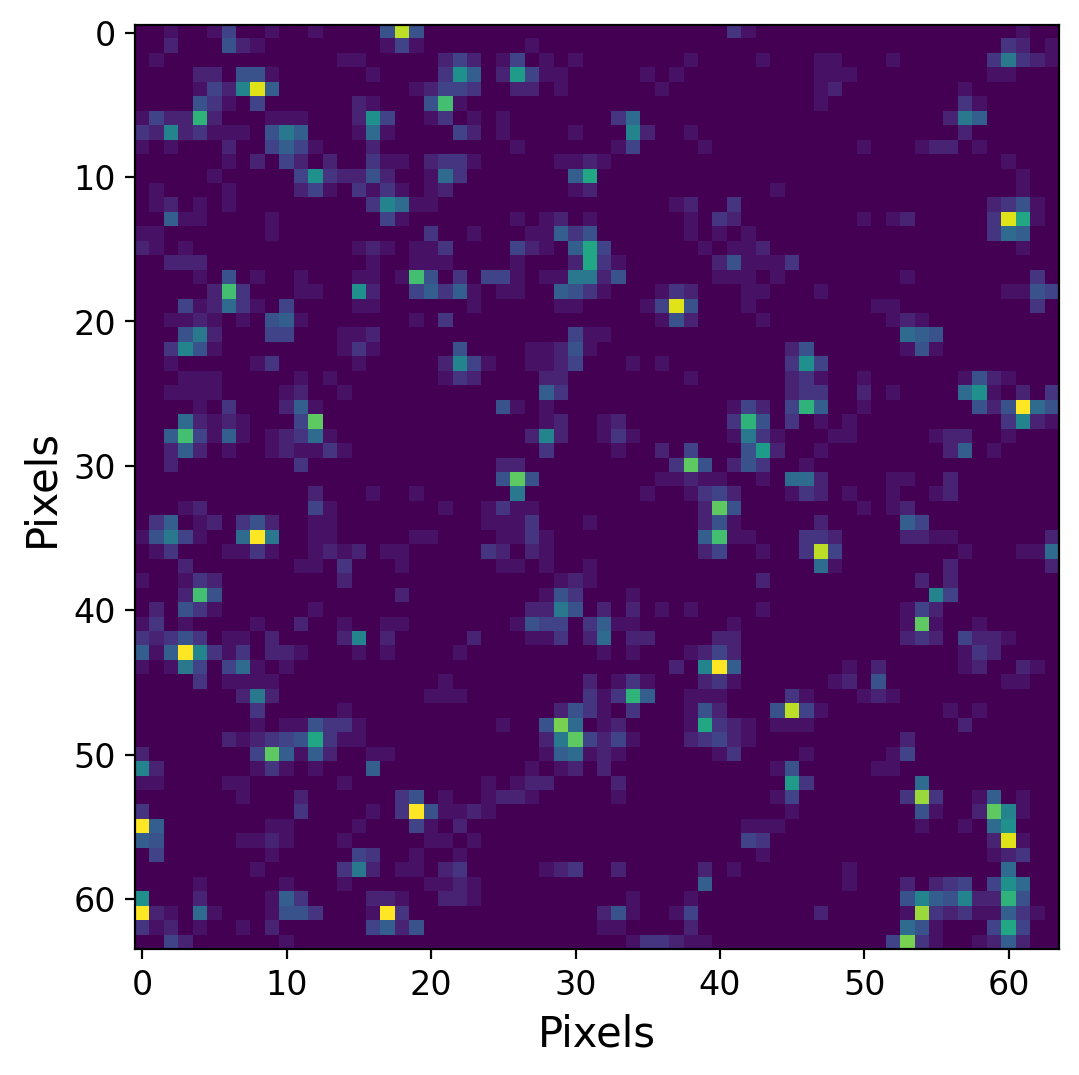

In [49]:
#>>>RUN: L24.5-runcell01

from scipy.stats import binned_statistic_2d
from astropy.convolution import convolve, Gaussian2DKernel


def simulate_sources(amp_b, exp_b, s_min=0.5, s_max=50.0, box_size=1., resolution=64, sigma_psf=0.01):
    """ Simulate a map of point sources with mean counts drawn from a power law (Pareto) distribution dn/ds = amp_b * s ** exp_b
    """
    # Get number of sources by analytically integrating dn/ds and taking Poisson realization
    n_sources = np.random.poisson(-amp_b * (s_min ** (exp_b - 1)) / (exp_b - 1))

    # Draw fluxes from truncated power law amp_b * s ** (exp_b - 1), with s_min and s_max as the bounds
    fluxes = draw_powerlaw_flux(n_sources, s_min, s_max, exp_b)

    positions = np.random.uniform(0., box_size, size=(n_sources, 2))
    bins = np.linspace(0, box_size, resolution + 1)

    pixel_size = box_size / resolution
    kernel = Gaussian2DKernel(x_stddev=1.0 * sigma_psf / pixel_size)

    mu_signal = binned_statistic_2d(x=positions[:, 0], y=positions[:, 1], values=fluxes, statistic='sum', bins=bins).statistic
    counts = np.random.poisson(convolve(mu_signal, kernel))
                
    return fluxes, counts

def draw_powerlaw_flux(n_sources, s_min, s_max, exp_b):
    """
    Draw from a power law with slope `exp_b` and min/max mean counts `s_min` and `s_max`. From:
    https://stackoverflow.com/questions/31114330/python-generating-random-numbers-from-a-power-law-distribution
    """
    u = np.random.uniform(0, 1, size=n_sources)
    s_low_u, s_high_u = s_min ** (exp_b + 1), s_max ** (exp_b + 1)
    return (s_low_u + (s_high_u - s_low_u) * u) ** (1.0 / (exp_b + 1.0))

fluxes, counts = simulate_sources(amp_b=200., exp_b=-1.2)
plt.imshow(counts, cmap='viridis', vmax=20)
plt.xlabel("Pixels")
plt.ylabel("Pixels")

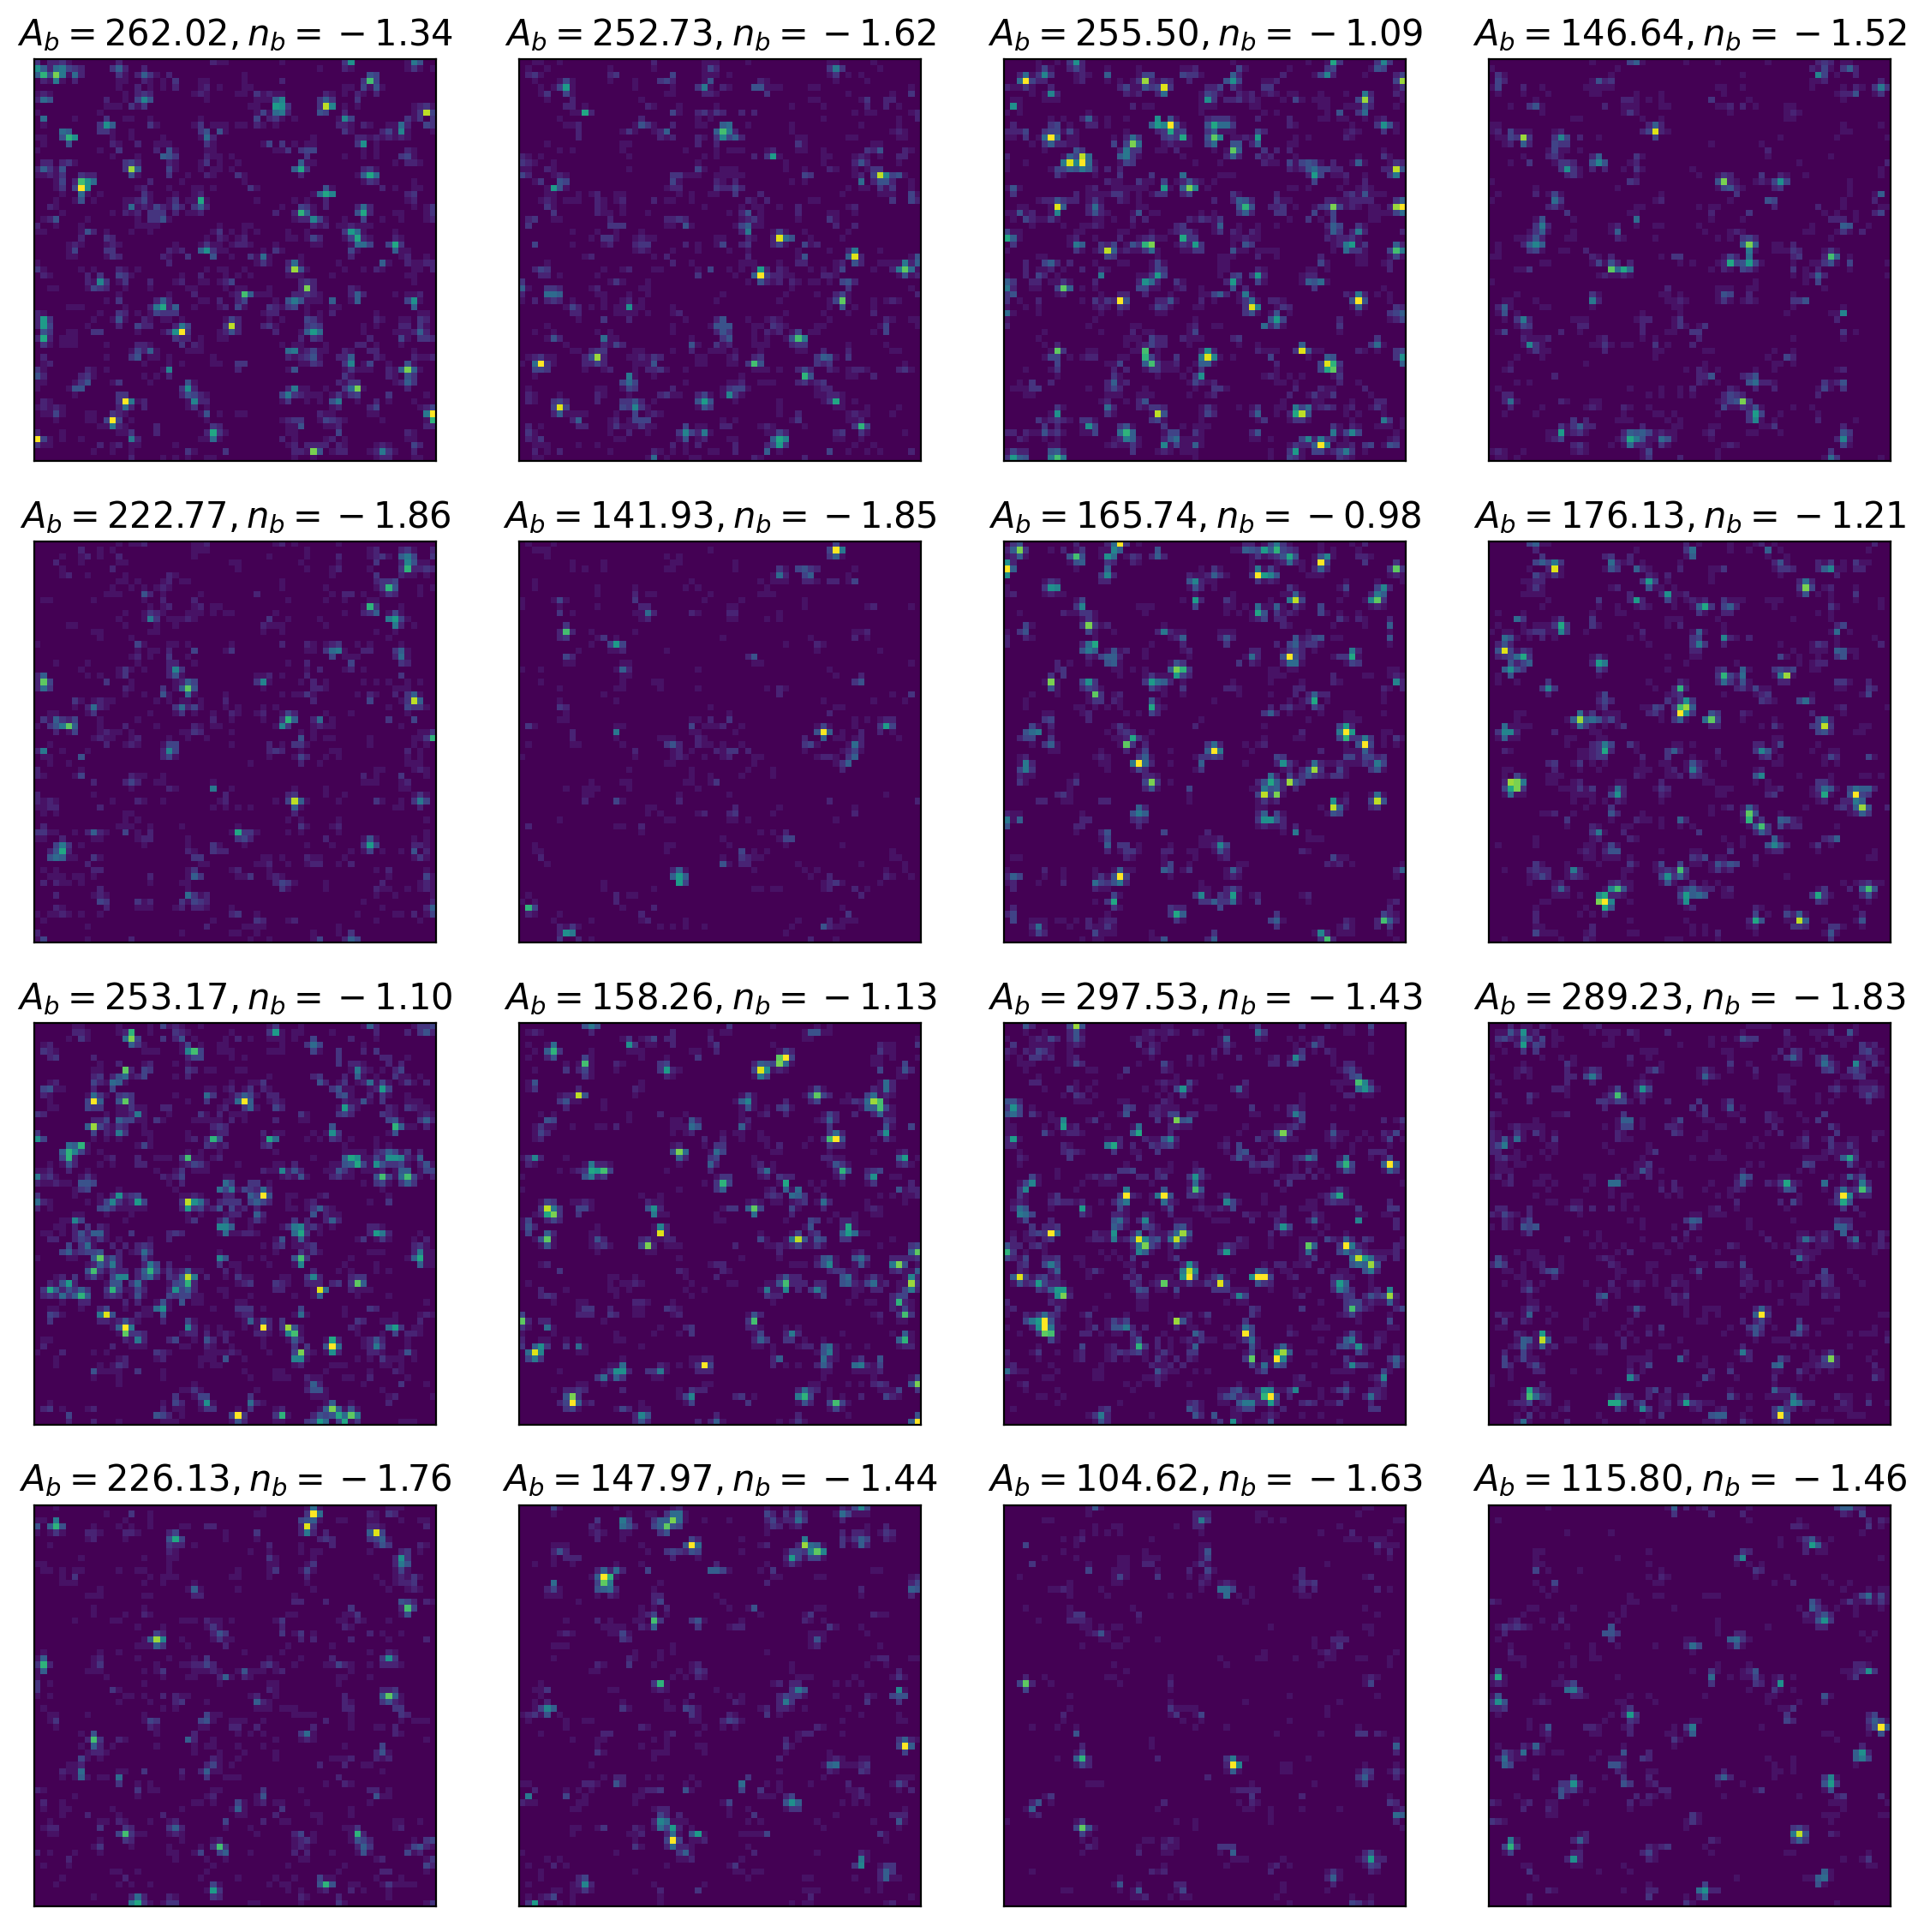

In [50]:
#>>>RUN: L24.5-runcell02

# Draw parameters from the prior
n_params = 16

amp_b_prior = (100., 300.)
exp_b_prior = (-2.0, -0.5)

amp_bs = np.random.uniform(amp_b_prior[0], amp_b_prior[1], n_params)
exp_bs = np.random.uniform(exp_b_prior[0], exp_b_prior[1], n_params)

# Plot the data samples on a grid
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, ax in enumerate(axes.flatten()):
    fluxes, counts = simulate_sources(amp_b=amp_bs[i], exp_b=exp_bs[i])
    im = ax.imshow(counts, cmap='viridis', vmax=20)
    ax.set_title(f'$A_b={amp_bs[i]:.2f}, n_b={exp_bs[i]:.2f}$')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [51]:
#>>>RUN: L24.5-runcell03

n_train = 20_000

# Sample from prior, then simulate
theta_samples = np.random.uniform(low=[10., -3.], high=[200., -0.99], size=(n_train, 2))
x_samples = np.array([simulate_sources(theta[0], theta[1])[1] for theta in tqdm(theta_samples)])

# Convert to torch tensors
theta_samples = torch.Tensor(theta_samples)
x_samples = torch.Tensor(x_samples)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std


100%|███████████████████████████████████| 20000/20000 [00:09<00:00, 2119.72it/s]


In [52]:
#>>>RUN: L24.5-runcell04

val_fraction = 0.1
batch_size = 64
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)


In [53]:
#>>>RUN: L24.5-runcell05

class CNN(nn.Module):
    """ Simple CNN feature extractor.
    """
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        
        x = x.unsqueeze(1)  # Add channel dim
        
        x = self.pool1(F.leaky_relu(self.conv1(x), negative_slope=0.02))
        x = self.pool2(F.leaky_relu(self.conv2(x), negative_slope=0.02))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)

        return x


#functions defined in previous sections, redefined here
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow


class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, d_context=16,d_hidden=32):
        super().__init__()
        self.featurizer = featurizer
        self.flow = get_flow(d_in=2, d_hidden=d_hidden, d_context=d_context, n_layers=4)

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        context = self(x)
        return -self.flow.log_prob(inputs=theta, context=context)

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [54]:
#>>>RUN: L24.5-runcell06

npe = NeuralPosteriorEstimator(featurizer=CNN(output_dim=32), d_context=32)
npe.loss(x_samples[:64], theta_samples[:64])

tensor([5.2383, 5.1202, 5.0794, 5.2013, 5.1729, 5.1234, 5.2630, 5.2287, 5.2864,
        5.3325, 5.1408, 5.2660, 5.0941, 5.1521, 5.2449, 5.1992, 5.1558, 5.1627,
        5.1455, 5.2597, 5.2839, 5.1122, 5.2679, 5.4090, 5.1519, 5.4545, 5.1684,
        5.3724, 5.2670, 5.2093, 5.0944, 5.2221, 5.2713, 5.1584, 5.2990, 5.2904,
        5.1581, 5.1678, 5.1941, 5.1958, 5.1043, 5.2132, 5.2480, 5.2294, 5.1773,
        5.2038, 5.1625, 5.2096, 5.1597, 5.1769, 5.2391, 5.1260, 5.1134, 5.1634,
        5.2027, 5.3706, 5.1871, 5.1386, 5.2838, 5.1279, 5.1284, 5.1430, 5.1790,
        5.2573], grad_fn=<NegBackward0>)

In [55]:
#>>>RUN: L24.5-runcell07

trainer = pl.Trainer(max_epochs=15)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
#>>>RUN: L24.5-runcell08

npe = npe.eval()

In [ ]:
#>>>RUN: L24.5-runcell09

params_test = np.array([15., -1.4])
x_test = simulate_sources(params_test[0], params_test[1])[1]

In [ ]:
#>>>RUN: L24.5-runcell10

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm.unsqueeze(0))

samples_test = npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

corner.corner(samples_test, labels=["amp", "exp"], truths=params_test);

In [ ]:
#>>>RUN: L24.5-runcell11

n_test = 200  # How many test samples to draw for coverage test

# Get samples 
x_test = torch.Tensor([simulate_sources(params_test[0], params_test[1])[1] for _ in range(n_test)])
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

# and featurize
context = npe.featurizer(x_test_norm)

# Get posterior for all samples together in a batch
samples_test = npe.flow.sample(num_samples=1000, context=context) * theta_std + theta_mean
samples_test = samples_test.detach().numpy()

In [ ]:
#>>>RUN: L24.5-runcell12

def hpd(samples, credible_mass=0.95):
    """Compute highest posterior density (HPD) of array for given credible mass."""
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * sorted_samples.shape[0]))
    n_intervals = sorted_samples.shape[0] - interval_idx_inc
    interval_width = np.zeros(n_intervals)
    for i in range(n_intervals):
        interval_width[i] = sorted_samples[i + interval_idx_inc] - sorted_samples[i]
    hdi_min = sorted_samples[np.argmin(interval_width)]
    hdi_max = sorted_samples[np.argmin(interval_width) + interval_idx_inc]
    return hdi_min, hdi_max

hpd(samples_test[0, :, 0], credible_mass=0.2)

In [ ]:
#>>>RUN: L24.5-runcell13

p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = hpd(sample, credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

In [ ]:
#>>>RUN: L24.5-runcell14

# Make two plots, one for each parameter

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p_nominals, contains_true[0].sum(0) / n_test)
ax[0].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[0].set_xlabel("Nominal coverage")
ax[0].set_ylabel("Empirical coverage")
ax[0].set_title("Coverage for amplitude")

ax[1].plot(p_nominals, contains_true[1].sum(0) / n_test)
ax[1].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[1].set_xlabel("Nominal coverage")
ax[1].set_ylabel("Empirical coverage")
ax[1].set_title("Coverage for exponent")

<a name='exercises_24_5'></a>     

| [Top](#section_24_0) | [Restart Section](#section_24_5) | 


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Exercise 24.5.1</span>

**Which one of the following answer options are acceptable calibration results for a posterior estimator?** In other words, which *likely* result would be preferable? Here, "Overconfident" means that one expects the true values to appear within a certain probability interval more often than is found using test samples. This was clearly the case for the amplitude in the example studied in the related video. In contrast, "Conservative" means the opposite, namely that the true value is found more often than expected in the given interval. This is the case for the exponent in the video, albeit at a much smaller level.

A) Overconfident\
B) Conservative\
C) Perfectly calibrated\
D) Perfectly calibrated or conservative\
E) Perfectly calibrated or overconfident

<br>